In [114]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import seaborn as sns

# Double spending time distribution with random walk

The difference between the number of blocks of the public blockchain and the private one is given by 
$$
R_0 = z,\text{ }R_n = R_{n-1}+Y_n,\text{ for }n\geq1,
$$
where the $Y_i$'s are iid with probability mass fuunction 

$$
\mathbb{P}(Y = 1)=p\text{ and }\mathbb{P}(Y = -1)=1-p = q.
$$

Define the double spending time as $\tau_0 = \inf\{n\geq0\text{ ; }R_n = 0\}$

We wish to verify the following formula

$$
\mathbb{P}(\tau_0 = n|R_0 = z) = \frac{z}{n}\binom{n}{(n-z)/2}p^{(n-z)/2}q^{(n+z)/2},
$$

via simulations.

1) Write a function **pmf_ds** that compute the probability mass function of the double spending time. the **pmf_ds** takes as argument 

- p the hashpower of the honest miners
- z the number of blocks that the honest chain is ahead of the dishonest one
- n the time horizon

and returns the $\mathbb{P}(\tau_0 = n|R_0 = z)$. Evaluate the ds probability with $p= 2/3, z = 2,$ and $n = 6$.

In [115]:
def pmf_ds(p, z, n):
    q = 1-p
    if z > n or (n - z) % 2 == 1:
        res = 0
    else:
        a = int((n - z) / 2)
        res = z / n * sp.binom(n, a) * p**(a) * q**(a + z)
    return(res)
p, z, n = 2/3, 2, 6
pmf_ds(p, z, n)

0.02743484224965708

2) Verify that it checks out with the probability of double spending

In [116]:
sum([pmf_ds(p, z, k) for k in range(100)]), ((1-p)/p)**z

(0.24998389315180378, 0.2500000000000001)

3) Write a function **sample_ds_time** that sample value of $\tau_0$ up to given time horizon $n$. **pmf_ds_MC** takes as argument

- K the number of MC runs
- n the time horizon (beyond which we state that $\tau_0 = \infty$)
- p the hashpower of the honest miners
- z the number of blocks that the honest chain is ahead of the dishonest one

and returns a vector of values of $\tau_0$. Estimate the ds probability with $p= 2/3, z = 2,n = 6$ and $K = 10,000$.

In [85]:
def sample_ds_time(p, z, n, K):
    tau = []
    for k in range(K):

        Y_n = 2*np.random.binomial(1, p, size = n) -1
        R_n = z + np.cumsum(Y_n)
        # R_n = np.array([0, 0,0])
        if np.any(np.where(R_n == 0)[0]):
            tau.append(np.where(R_n == 0)[0][0]+1)
        else:
            tau.append(np.NaN)
    return(np.array(tau))
p, z, n, K = 2/3, 2, 7, 10000
tau = sample_ds_time(p, z, n, K)
np.mean(tau == 6)

0.03

4) Compare the Monte Carlo approximation and the true value by plotting the values $\mathbb{P}(\tau_0 = n|R_0 = z)$ for $n =1,\ldots,10$. We want the true value surrounded by the $5\%$ confidence band of the MC estimator. 

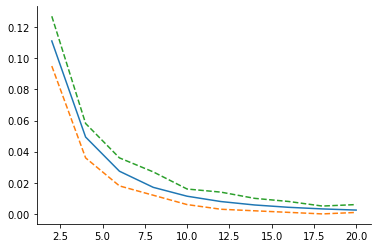

In [112]:
n = np.arange(1,11,1)*2
p, z, K = 2/3, 2, 1000
true_value = [pmf_ds(p, z, k) for k in n]
MC_values = []
for i in range(100):
    tau = sample_ds_time(p, z, max(n), K)
    MC_values.append([np.mean(tau == k) for k in n])
    
MC_bands = np.quantile(np.matrix(MC_values), q = np.array([0.05, 0.95]), axis = 0)    
plt.plot(n, true_value)
plt.plot(n, MC_bands[0,:], linestyle = "dashed")
plt.plot(n, MC_bands[1,:], linestyle = "dashed")
sns.despine()